# Levarage PubChem IDs for predicting the Dopamine D3 receptor antagonists based on RDKit transformed SMILES

### Content   <a name="content"></a>

1. [Upload and analyse PubChem BioAssay AID 652054 on D3 receptor ](#1)
2. [Create a data frame with CIDs, SIDs and targets](#2)
3. [Upload and analyse PubChem BioAssay AID 1996 on water solubility ](#3)
4. [Create the final data frame, crossing the data frame that holds the targets with the water solubility data frame](#4)
5. [Create RDkit features derived from SMILES](#5)
6. [Data preperation for Machine learning](#6)
7. [Balancing](#7)
8. [Machine Learning](#8)
9. [Cross validation](#9)
10. [Scrutinise for overfitting](#10)
11. [Hyperparameter tuning](#11)
12. [Final ML model](#12)
13. [Plot the learning curve ans AUC](#13)
14. [Confusion matrix](#14)
15. [Matthews Correlation Coefficient](#15)
16. [Classification report](#16)
17. [LIME analyse](#17)

## Upload and analyse PubChem BioAssay AID 652054 on D3 receptor <a name="1"></a>

In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Disable RDKit warnings globally before defining the function
RDLogger.DisableLog('rdApp.*')

import rdkit
print(rdkit.__version__)

2023.09.5


In [2]:
import pandas as pd 

# load the BioAssay PubChem AID 652054 dataset
df_targets = pd.read_csv('1.D3_PubChem_AID_652054.csv', low_memory=False)

# To avoid truncation of some columns during data frame display
pd.set_option('display.max_columns', None) 

# Display the data frame
print('Shape of the data frame: ', df_targets.shape)
df_targets.head()

Shape of the data frame:  (364367, 26)


,PUBCHEM_RESULT_TAG,SID,CID,PUBCHEM_EXT_DATASOURCE_SMILES,target,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Phenotype,Potency,Efficacy,Analysis Comment,Activity_Score,Curve_Description,Fit_LogAC50,Fit_HillSlope,Fit_R2,Fit_InfiniteActivity,Fit_ZeroActivity,Fit_CurveClass,Excluded_Points,Max_Response,Activity at 2.300 uM,Activity at 11.50 uM,Activity at 57.50 uM,Compound QC;;
0,1,124755913,53301729.0,COC1=C(C=C(C=C1)C2=C(NC(=C2C(=O)C3=CC=C(C=C3)B...,Active,90,http://assay.nih.gov/htsws/rest/display/D3-arr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-73.0809,-25.9891,-73.0809,NaN,QC'd by Alexander Doemling - Univ. of Pittsbur...
1,2,124755904,53301720.0,COC1=C(C=C(C=C1)C2=C(NC(=C2C(=O)C3=CC=CC=C3)N)...,Active,90,http://assay.nih.gov/htsws/rest/display/D3-arr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-66.7325,-20.3722,-66.7325,NaN,QC'd by Alexander Doemling - Univ. of Pittsbur...
2,3,125306376,53383657.0,C1CN(CCN1)C(=O)C2=C(SC(=C2)C3=CC=CC=C3)N,Active,90,http://assay.nih.gov/htsws/rest/display/D3-arr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-54.0946,-1.5577,-54.0946,NaN,QC'd by Alexander Doemling - Univ. of Pittsbur...
3,4,124753928,53299937.0,C1=CC=C(C=C1)C(=O)C2=C(C(=C(N2)N)C(=O)N)C3=CC=...,Active,90,http://assay.nih.gov/htsws/rest/display/D3-arr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-52.0484,-2.9351,-52.0484,NaN,QC'd by Alexander Doemling - Univ. of Pittsbur...
4,5,124755898,53301714.0,C1=CC=C(C=C1)C(=O)C2=C(C(=C(N2)N)C(=O)N)C3=CC=...,Inconclusive,50,http://assay.nih.gov/htsws/rest/display/D3-arr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-43.0771,-45.0704,-43.0771,NaN,QC'd by Alexander Doemling - Univ. of Pittsbur...


In [3]:
df_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364367 entries, 0 to 364366
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   PUBCHEM_RESULT_TAG             364367 non-null  int64  
 1   SID                            364367 non-null  int64  
 2   CID                            364366 non-null  float64
 3   PUBCHEM_EXT_DATASOURCE_SMILES  364366 non-null  object 
 4   target                         364367 non-null  object 
 5   PUBCHEM_ACTIVITY_SCORE         364367 non-null  int64  
 6   PUBCHEM_ACTIVITY_URL           364367 non-null  object 
 7   PUBCHEM_ASSAYDATA_COMMENT      0 non-null       float64
 8   Phenotype                      0 non-null       float64
 9   Potency                        0 non-null       float64
 10  Efficacy                       0 non-null       float64
 11  Analysis Comment               0 non-null       float64
 12  Activity_Score                

In [4]:
# Remove duplicates 
df_targets.drop_duplicates()
df_targets.shape  # 353737 means no duplicates

(364367, 26)

In [5]:
# Remove compounds with missing CID-s
df_targets = df_targets[df_targets['CID'].notna()]
df_targets.shape

(364366, 26)

In [6]:
# Remove compounds with missing SID-s
df_targets = df_targets[df_targets['SID'].notna()]
df_targets.shape

(364366, 26)

In [7]:
import numpy as np
# Turn CID float data type into integer
df_targets['CID'] = df_targets['CID'].astype(np.int64) 
df_targets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 364366 entries, 0 to 364366
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   PUBCHEM_RESULT_TAG             364366 non-null  int64  
 1   SID                            364366 non-null  int64  
 2   CID                            364366 non-null  int64  
 3   PUBCHEM_EXT_DATASOURCE_SMILES  364366 non-null  object 
 4   target                         364366 non-null  object 
 5   PUBCHEM_ACTIVITY_SCORE         364366 non-null  int64  
 6   PUBCHEM_ACTIVITY_URL           364366 non-null  object 
 7   PUBCHEM_ASSAYDATA_COMMENT      0 non-null       float64
 8   Phenotype                      0 non-null       float64
 9   Potency                        0 non-null       float64
 10  Efficacy                       0 non-null       float64
 11  Analysis Comment               0 non-null       float64
 12  Activity_Score                 0 no

In [8]:
# Analise the Active compounds
df_Active = df_targets[df_targets['target']=='Active']
df_Active.describe(include='all')

,PUBCHEM_RESULT_TAG,SID,CID,PUBCHEM_EXT_DATASOURCE_SMILES,target,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Phenotype,Potency,Efficacy,Analysis Comment,Activity_Score,Curve_Description,Fit_LogAC50,Fit_HillSlope,Fit_R2,Fit_InfiniteActivity,Fit_ZeroActivity,Fit_CurveClass,Excluded_Points,Max_Response,Activity at 2.300 uM,Activity at 11.50 uM,Activity at 57.50 uM,Compound QC;;
count,9117.000000,9.117000e+03,9.117000e+03,9117,9117,9117.0,9117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9117.000000,9103.000000,9117.000000,1651.000000,9117
unique,NaN,NaN,NaN,9106,1,NaN,9117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82
top,NaN,NaN,NaN,COC1=CC=CC=C1N2CCN(CC2)CC(COC3=CC=CC=C3CC=C)O.Cl,Active,NaN,http://assay.nih.gov/htsws/rest/display/D3-arr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QC'd by DPISMR;;
freq,NaN,NaN,NaN,2,9117,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1751
mean,162265.400351,3.639120e+07,1.532145e+07,NaN,NaN,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-71.923504,-24.694481,-63.138472,-67.655262,NaN
std,105988.247321,3.204856e+07,2.732962e+07,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.107738,29.894778,30.653640,13.077494,NaN
min,1.000000,8.421370e+05,1.318000e+03,NaN,NaN,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-272.950000,-177.089000,-272.950000,-135.893000,NaN
25%,84528.000000,1.473833e+07,1.825654e+06,NaN,NaN,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-82.129700,-38.729950,-80.703900,-75.776600,NaN
50%,131291.000000,2.480030e+07,3.711067e+06,NaN,NaN,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-67.154900,-18.666400,-63.401000,-65.223700,NaN
75%,264357.000000,4.971666e+07,1.619570e+07,NaN,NaN,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-56.753100,-3.961350,-52.840000,-56.832350,NaN


In [9]:
# Amalise the Inactive compound
df_Inactive = df_targets[df_targets['target']=='Inactive']
df_Inactive.describe(include='all')

,PUBCHEM_RESULT_TAG,SID,CID,PUBCHEM_EXT_DATASOURCE_SMILES,target,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Phenotype,Potency,Efficacy,Analysis Comment,Activity_Score,Curve_Description,Fit_LogAC50,Fit_HillSlope,Fit_R2,Fit_InfiniteActivity,Fit_ZeroActivity,Fit_CurveClass,Excluded_Points,Max_Response,Activity at 2.300 uM,Activity at 11.50 uM,Activity at 57.50 uM,Compound QC;;
count,339862.000000,3.398620e+05,3.398620e+05,339862,339862,339862.0,339862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,339862.000000,338542.000000,339862.000000,31187.000000,339862
unique,NaN,NaN,NaN,339611,1,NaN,339862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105
top,NaN,NaN,NaN,C1(C(C(C(C(C1O)O)O)O)O)O,Inactive,NaN,http://assay.nih.gov/htsws/rest/display/D3-arr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QC'd by Enamine;;
freq,NaN,NaN,NaN,3,339862,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49360
mean,183533.228090,3.687369e+07,1.270212e+07,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.374578,0.004487,1.280095,2.534716,NaN
std,105001.556434,2.854622e+07,2.386607e+07,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.295728,14.894771,16.226770,19.479251,NaN
min,10.000000,8.421210e+05,6.000000e+00,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-29.999900,-189.364000,-115.769000,-29.995000,NaN
25%,93427.250000,1.740965e+07,1.810025e+06,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.744450,-8.068375,-8.772050,-8.890300,NaN
50%,185712.500000,2.483230e+07,3.452006e+06,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.655800,0.103150,0.453550,1.966500,NaN
75%,274248.750000,4.973590e+07,1.609912e+07,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.277550,7.974075,9.219375,11.600950,NaN


[<a href="#content">Back to top</a>]

## Create a data frame with CIDs, SIDs and targets <a name="2"></a>

In [10]:
# Create a data frame containing the classification targets
df_targets = df_targets [['CID', 'SID', 'PUBCHEM_EXT_DATASOURCE_SMILES', 'target']]

# Display the data frame
print('Shape of df_targets : ', df_targets .shape)
df_targets .head()

Shape of df_targets :  (364366, 4)


,CID,SID,PUBCHEM_EXT_DATASOURCE_SMILES,target
0,53301729,124755913,COC1=C(C=C(C=C1)C2=C(NC(=C2C(=O)C3=CC=C(C=C3)B...,Active
1,53301720,124755904,COC1=C(C=C(C=C1)C2=C(NC(=C2C(=O)C3=CC=CC=C3)N)...,Active
2,53383657,125306376,C1CN(CCN1)C(=O)C2=C(SC(=C2)C3=CC=CC=C3)N,Active
3,53299937,124753928,C1=CC=C(C=C1)C(=O)C2=C(C(=C(N2)N)C(=O)N)C3=CC=...,Active
4,53301714,124755898,C1=CC=C(C=C1)C(=O)C2=C(C(=C(N2)N)C(=O)N)C3=CC=...,Inconclusive


In [11]:
# Check the classes in the bioassay
df_targets['target'].value_counts()

target
Inactive        339862
Inconclusive     15387
Active            9117
Name: count, dtype: int64

In [12]:
# Remove the Inconclusive samples 
df_targets = df_targets[df_targets['target']!='Inconclusive']
df_targets['target'].value_counts()

target
Inactive    339862
Active        9117
Name: count, dtype: int64

In [13]:
# Set the binary targets to "1" for an active antagonist and "0" for inactive 
df_targets = df_targets.copy()

# Create a dictionary
targets = {'Active' : 1,
           'Inactive' : 0}

# Replace the names with binary values set up in the dictionary targets
df_targets.target = [targets[item] for item in df_targets.target]

# Check how many unique values there are in the 'target' column
print('Unique values: ', df_targets['target'].unique())

# Count each of the binary targets
df_targets['target'].value_counts()

Unique values:  [1 0]


target
0    339862
1      9117
Name: count, dtype: int64

In [14]:
# Display the data frame
print('Shape of the df_targets: ', df_targets.shape)
df_targets.head()

Shape of the df_targets:  (348979, 4)


,CID,SID,PUBCHEM_EXT_DATASOURCE_SMILES,target
0,53301729,124755913,COC1=C(C=C(C=C1)C2=C(NC(=C2C(=O)C3=CC=C(C=C3)B...,1
1,53301720,124755904,COC1=C(C=C(C=C1)C2=C(NC(=C2C(=O)C3=CC=CC=C3)N)...,1
2,53383657,125306376,C1CN(CCN1)C(=O)C2=C(SC(=C2)C3=CC=CC=C3)N,1
3,53299937,124753928,C1=CC=C(C=C1)C(=O)C2=C(C(=C(N2)N)C(=O)N)C3=CC=...,1
9,53301739,124755923,C1=CC=C(C=C1)C(=O)C2=C(C(=C(N2)N)C#N)C3=CC=C(C...,0


In [15]:
# Creat a dataframe with full set of target 1 for latter use
df_targets_1 = df_targets[df_targets['target']==1]

[<a href="#content">Back to top</a>]

## Upload and analyse PubChem BioAssay AID 1996 on water solubility <a name="3"></a>

In [16]:
# Load data from PubChem BioAssay AID 1996 
df_solubility = pd.read_csv('0.Solubility_pubChem_AID_1996.csv')

# Display the data frame
print('Shape of df_solubility: ', df_solubility.shape)
df_solubility.head()

Shape of df_solubility:  (57859, 30)


,PUBCHEM_RESULT_TAG,SID,CID,PUBCHEM_EXT_DATASOURCE_SMILES,OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Solubility at pH 7.4_Qualifier_Mean,Solubility at pH 7.4_Mean,Test Concentration_1,Solubility at pH 7.4_Qualifier_1,Solubility at pH 7.4_1,Solubility at pH 7.4_Comment_1,Solubility of Astemizole at pH 7.4_Qualifier_1,Solubility of Astemizole at pH 7.4_1,Solubility of Sulfamethizole at pH 7.4_Qualifier_1,Solubility of Sulfamethizole at pH 7.4_1,Solubility of Imipramine HCl at pH 7.4_Qualifier_1,Solubility of Imipramine HCl at pH 7.4_1,Test Concentration_2,Solubility at pH 7.4_Qualifier_2,Solubility at pH 7.4_2,Solubility at pH 7.4_Comment_2,Solubility of Astemizole at pH 7.4_Qualifier_2,Solubility of Astemizole at pH 7.4_2,Solubility of Sulfamethizole at pH 7.4_Qualifier_2,Solubility of Sulfamethizole at pH 7.4_2,Solubility of Imipramine HCl at pH 7.4_Qualifier_2,Solubility of Imipramine HCl at pH 7.4_2
0,1,24826444,2374148,COC1=CC=C(C=C1)OCC2=NNC(=S)N2N,Active,40,NaN,NaN,=,10.85,200,<,0.1,Below LOQ,=,14.2,>,40.5,>,47.5,200.0,=,21.6,NaN,=,27.7,>,40.5,>,47.5
1,2,49669186,5295761,CC1=CC(=C(C=C1)NC2=NC3=CC=CC=C3N4C2=NN=C4)Cl,Inactive,0,NaN,NaN,<,0.10,200,<,0.1,Below LOQ,=,12.3,>,40.5,>,47.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,49669768,22431387,CC1=CC(=CC=C1)CCNC2=NC3=C(C=C(C=C3)C)N4C2=NN=C4,Inactive,0,NaN,NaN,<,0.10,200,<,0.1,Below LOQ,=,12.3,>,40.5,>,47.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,8139962,14296,CC1=C(N=C(C(=N1)C)C)C,Inactive,0,NaN,NaN,<,0.10,200,<,0.1,Below LOQ,=,11.4,>,40.5,>,47.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,24803435,865684,CC1=CC2=NC(=C(C=C2C=C1)C#N)NC3=CC=CC=C3OC,Inactive,0,NaN,NaN,<,0.20,200,<,0.2,Below LOQ,=,11.4,>,40.5,>,47.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df_solubility.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57859 entries, 0 to 57858
Data columns (total 30 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   PUBCHEM_RESULT_TAG                                  57859 non-null  int64  
 1   SID                                                 57859 non-null  int64  
 2   CID                                                 57859 non-null  int64  
 3   PUBCHEM_EXT_DATASOURCE_SMILES                       57859 non-null  object 
 4   OUTCOME                                             57859 non-null  object 
 5   PUBCHEM_ACTIVITY_SCORE                              57859 non-null  int64  
 6   PUBCHEM_ACTIVITY_URL                                0 non-null      float64
 7   PUBCHEM_ASSAYDATA_COMMENT                           0 non-null      float64
 8   Solubility at pH 7.4_Qualifier_Mean                 57859 non-null  object 


In [18]:
# Create the desired data frame with CID and SID for sifting 
df_solubility = df_solubility[['SID', 'CID']]

# Display the data frame
print('Shape of the data frame: ', df_solubility.shape)
df_solubility.head()

Shape of the data frame:  (57859, 2)


,SID,CID
0,24826444,2374148
1,49669186,5295761
2,49669768,22431387
3,8139962,14296
4,24803435,865684


[<a href="#content">Back to top</a>]

## Create the final data frame, crossing the data frame that holds the targets with the water solubility data frame  <a name="4"></a>

In [19]:
# Sift the main data frame with targets using the solubility data frame 
df = pd.merge(df_targets, df_solubility, on=["CID", "SID"])

# Display the data frame
print('Shape of the data frame: ', df.shape)
df.head()

Shape of the data frame:  (55780, 4)


,CID,SID,PUBCHEM_EXT_DATASOURCE_SMILES,target
0,24747098,49644873,COC1=CC=C(C=C1)CN2CCC(CC2)C(=O)C3=CC=C(C=C3)F,1
1,24746949,49643155,CCNC(=S)NC1CC2CCCC(C1)N2CC3=CC=C(C=C3)C,1
2,3217171,49644315,C1CC2CC(CC1N2CC3=CC=CC=C3)NC(=O)C4=CC(=CC=C4)F,1
3,3218131,24797390,CC1=CC=C(C=C1)CN2C3CCCC2CC(C3)NC(=S)NC,1
4,4763,51087546,CCC1(C(=O)NC(=O)NC1=O)C2=CC=CC=C2,1


In [20]:
# Count values of the sifted data frame 
df['target'].value_counts()

target
0    54951
1      829
Name: count, dtype: int64

In [21]:
# Create a data frame with target 0
df_0 = df[df['target']==0]

# Concatenate the sifted target 0 with the original target 1
df = pd.concat([df_0, df_targets_1])

df.to_csv("HF_dopamine_D3_receptor_antagonists_CID_SID.csv", index=False)
# Display the data frame
print('Shape of the data frame: ', df.shape)
df.head()

Shape of the data frame:  (64068, 4)


,CID,SID,PUBCHEM_EXT_DATASOURCE_SMILES,target
135,787348,47203112,COC(=O)C1CCN(CC1)C(=O)/C=C/C2=CC3=C(C=C2)OCO3,0
136,6858680,47201572,CCOC1=C(C=C(C=C1)/C=N/N2C(=NN=N2)N)OCC,0
137,1093787,49728600,CC1=CC=C(C=C1)C2=CC(=NO2)C(=O)N3CCCCCC3,0
138,16192991,24809896,CCCCNC(=S)N1CCN(CC1)C.C(=O)(C(=O)O)O,0
139,5765239,49726987,CC1CCCN(C1)C(=O)/C(=C/C2=CC=CO2)/NC(=O)C3=CC=C...,0


In [22]:
# Count the target
df['target'].value_counts()

target
0    54951
1     9117
Name: count, dtype: int64

In [23]:
# Shuffle the resulting data set
df = df.sample(
    frac = 1,        # Return entire dataframe
    random_state=1   # Make result reproducible
    ).reset_index(drop=True)

In [24]:
# Handle the part of target 1 in the test set 
df_1 = df[df['target']==1]

# Shuffle the resulting data set
df_1 = df_1.sample(
    frac = 1,        # Return entire dataframe
    random_state=1   # Make result reproducible
    ).reset_index(drop=True)


In [25]:
# Handle the part of target 0 in the test set 
df_0 = df[df['target']==0]

# Shuffle the resulting data set
df_0 = df_0.sample(
    frac = 1,        # Return entire dataframe
    random_state=1   # Make result reproducible
    ).reset_index(drop=True)

# Extract every nth row (e.g., every 4th row)
n = 4
df_0 = df_0[df_0.index % n == 0] 

# Shuffle the resulting data set
df_0 = df_0.sample(
    frac = 1,        # Return entire dataframe
    random_state=1   # Make result reproducible
    ).reset_index(drop=True)


In [26]:
# Create train and test dataframe for further manipulation 
df = pd.concat([df_0, df_1])

[<a href="#content">Back to top</a>]

## Create RDkit features derived from SMILES <a name="5"></a>

In [27]:
import time

# Record the start time
start_time = time.time()

In [28]:
# RDKit Featurization Function
def generate_rdkit_features(smiles, fp_size=1024, fp_radius=2):
    """
    Generates a dictionary of RDKit descriptors and ECFP4 fingerprints.
    
    Args:
        smiles (str): SMILES string.
        fp_size (int): Bit vector size for the fingerprint.
        fp_radius (int): Radius for Morgan (ECFP) fingerprint.
        
    Returns:
        dict: Dictionary of calculated features.
    """
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None  # Handle invalid SMILES

    features = {}

    # 1. Standard Physicochemical Descriptors (Highly Interpretable)
    features['MolWt'] = Descriptors.MolWt(mol)
    features['LogP'] = Descriptors.MolLogP(mol)
    features['NumHDonors'] = Descriptors.NumHDonors(mol)
    features['NumRotatableBonds'] = Descriptors.NumRotatableBonds(mol)
    features['TPSA'] = Descriptors.TPSA(mol)
    
    # 2. ECFP4 (Morgan) Fingerprints (Structure-based fragments)
    # Generate the fingerprint as a bit vector
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=fp_radius, nBits=fp_size)
    
    # Convert the bit vector to a NumPy array of integers (1s and 0s)
    fp_array = np.array(list(fp.ToBitString())).astype(int)
    
    # Store fingerprints as a single entry to be expanded later
    features['ECFP4_FP'] = fp_array
    
    return features

In [29]:
# Apply Featurization and Data Cleaning

# Apply the function to the SMILES column
df['Features'] = df['PUBCHEM_EXT_DATASOURCE_SMILES'].apply(generate_rdkit_features)

# Drop rows where SMILES was invalid
df.dropna(subset=['Features'], inplace=True)

# Separate the descriptor features (MolWt, LogP, etc.) and the fingerprints
descriptor_cols = list(df['Features'].iloc[0].keys())[:-1] # All keys except the last (ECFP4_FP)

# Expand features into new columns
df_features = pd.DataFrame(df['Features'].tolist())

# Extract Descriptors and Fingerprints
X_desc = df_features[descriptor_cols].values
X_fp = np.stack(df_features['ECFP4_FP'].values)
y = df['target'].values

print("✅ RDKit Featurization Complete.")
print(f"Descriptor Matrix Shape: {X_desc.shape}")
print(f"Fingerprint Matrix Shape: {X_fp.shape}")

✅ RDKit Featurization Complete.
Descriptor Matrix Shape: (22855, 5)
Fingerprint Matrix Shape: (22855, 1024)


[<a href="#content">Back to top</a>]

## Data preperation for Machine learning <a name="6"></a>

In [30]:
# Standardize Descriptors (Crucial for linear models/NNs)
scaler = StandardScaler()
X_desc_scaled = scaler.fit_transform(X_desc)

# Combine Features (Optional: Use Descriptors + Fingerprints)
# Concatenate the scaled descriptors with the binary fingerprints
X_combined = np.hstack([X_desc_scaled, X_fp])
print(f"Combined Feature Matrix Shape: {X_combined.shape}")

# Split Data for Training and Testing
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Keeping sets for the cross-validation  
X_cv = X_train
y_cv = y_train

print("\n--- ML Data Split Summary ---")
print(f"Training Samples: {len(X_train)}")
print(f"Testing Samples: {len(X_test)}")
print("Data is now ready for model training")

Combined Feature Matrix Shape: (22855, 1029)

--- ML Data Split Summary ---
Training Samples: 18284
Testing Samples: 4571
Data is now ready for model training


In [31]:
# Print the shape of each part
print("Shapes:")
print("X_train: ", X_train.shape)
print("X_test:  ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test:  ", y_test.shape)

Shapes:
X_train:  (18284, 1029)
X_test:   (4571, 1029)
y_train:  (18284,)
y_test:   (4571,)


[<a href="#content">Back to top</a>]

## Balancing <a name="7"></a>

[(0, 10990), (1, 7294)]


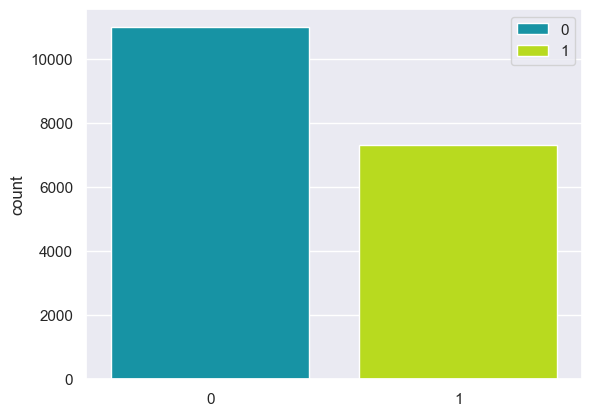

In [32]:
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns

# Plot the imbalance between the targets 
print(sorted(Counter(y_train).items()))
sns.set_style('white')
sns.set(font_scale=1)
plt.figure()
sns.countplot(x=y_train, hue=y_train, palette='nipy_spectral')
plt.show()

[(0, 10990), (1, 10990)]


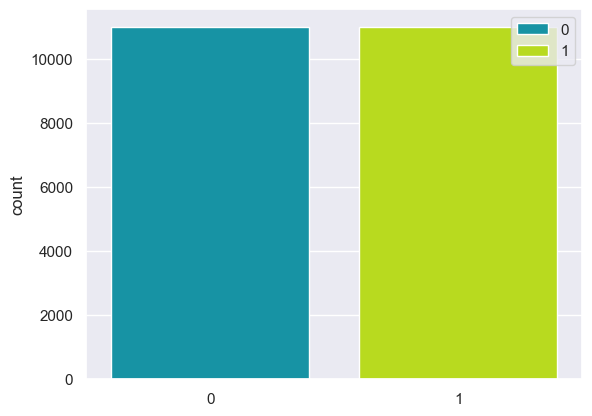

In [33]:
# from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

# Balance targets with Synthetic Minority Oversampling Technique
# smote = SMOTE(random_state=0)
ros = RandomOverSampler()

X_train, y_train = ros.fit_resample(X_train, y_train)

# Plot the balance between classification targets 
print(sorted(Counter(y_train).items()))
sns.set_style('white')
sns.set(font_scale=1)
plt.figure()
sns.countplot(x=y_train, hue=y_train,palette='nipy_spectral')
plt.show()

In [34]:
# Print the shape of each part
print("Shapes:")
print("X_train: ", X_train.shape)
print("X_test:  ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test:  ", y_test.shape)

Shapes:
X_train:  (21980, 1029)
X_test:   (4571, 1029)
y_train:  (21980,)
y_test:   (4571,)


[<a href="#content">Back to top</a>]

## Machine Learning <a name="8"></a>

In [35]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt

# Instantiate the estimator 
model = XGBClassifier(random_state=42)

# Train  
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
acc = round(accuracy_score(y_test, y_pred),3)
print('Accuracy: ', acc)
pre = round(precision_score(y_test, y_pred),3)
print('Precision: ', pre) 
rec = round(recall_score(y_test, y_pred),3)
print('Recall: ',rec) 
f1 = round(f1_score(y_test, y_pred),3)
print('F1: ', f1) 
roc = round(roc_auc_score(y_test, y_pred),3) 
print('ROC: ', roc)

Accuracy:  0.835
Precision:  0.825
Recall:  0.744
F1:  0.783
ROC:  0.82


In [36]:
# Record the end time
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Time elapsed: {elapsed_time:.4f} seconds")

Time elapsed: 27.6624 seconds


[<a href="#content">Back to top</a>]

## Cross-validation  <a name="9"></a>

In [37]:
# Five-fold cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix 

# Define the Model
model = XGBClassifier(max_depth=5, random_state=42)

# Number of folds
n_splits = 5

# Stratified K-Fold ensures balanced class distribution in each fold
# This ensures that each training and test fold has a similar percentage of class 1.
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store metrics from each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# --- 3. Cross-Validation Loop with Manual SMOTE Resampling ---
print(f"Performing {n_splits}-Fold Stratified Cross-Validation with Manual SMOTE...\n")

# Initialize the SMOTE object once
# smote= SMOTE(random_state=42)

for fold, (train_index, test_index) in enumerate(skf.split(X_cv, y_cv)):
    print(f"--- Fold {fold + 1}/{n_splits} ---")

    # Split data for the current fold
    X_train_cv, X_test_cv = X_cv[train_index], X_cv[test_index]
    y_train_cv, y_test_cv = y_cv[train_index], y_cv[test_index]

    # Report class distributions before resampling
    print(f"  Training set class distribution (Original): {np.bincount(y_train_cv)}")
    print(f"  Test set class distribution: {np.bincount(y_test_cv)}")

    # Apply SMOTE oversampling on the training split only
    # This is the step that replaces the imblearn pipeline logic.
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train_cv, y_train_cv)
    print(f"  Training set (after SMOTE) class distribution: {np.bincount(y_train_resampled)}")

    # Train the model on the resampled training data
    model.fit(X_train_resampled, y_train_resampled)

    # Make predictions on the *original, untouched* test data
    y_pred_cv = model.predict(X_test_cv)
    # Get probabilities for ROC AUC calculation
    y_prob_cv = model.predict_proba(X_test_cv)[:, 1]

    # Evaluate performance for the current fold
    accuracy = accuracy_score(y_test_cv, y_pred_cv)
    precision = precision_score(y_test_cv, y_pred_cv, zero_division=0)
    recall = recall_score(y_test_cv, y_pred_cv, zero_division=0)
    f1 = f1_score(y_test_cv, y_pred_cv, zero_division=0)
    roc_auc = roc_auc_score(y_test_cv, y_prob_cv)

    # Store scores
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall (Sensitivity): {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print(f"  Confusion Matrix:\n{confusion_matrix(y_test_cv, y_pred_cv)}\n")
    print("-" * 30)


# --- 4. Aggregate and Report Final Metrics ---
print("\n--- Cross-Validation Results Summary ---")

# Convert lists to NumPy arrays for easier statistical manipulation
accuracy_scores = np.array(accuracy_scores)
precision_scores = np.array(precision_scores)
recall_scores = np.array(recall_scores)
f1_scores = np.array(f1_scores)
roc_auc_scores = np.array(roc_auc_scores)

print(f"Average Accuracy: {np.mean(accuracy_scores):.4f} +/- {np.std(accuracy_scores):.4f}")
print(f"Average Precision: {np.mean(precision_scores):.4f} +/- {np.std(precision_scores):.4f}")
print(f"Average Recall: {np.mean(recall_scores):.4f} +/- {np.std(recall_scores):.4f}")
print(f"Average F1-Score: {np.mean(f1_scores):.4f} +/- {np.std(f1_scores):.4f}")
print(f"Average ROC AUC: {np.mean(roc_auc_scores):.4f} +/- {np.std(roc_auc_scores):.4f}")
print("\n--- Summary ---")
print("The standard deviation (+/-) indicates the stability of the model performance across the different folds.")

Performing 5-Fold Stratified Cross-Validation with Manual SMOTE...

--- Fold 1/5 ---
  Training set class distribution (Original): [8792 5835]
  Test set class distribution: [2198 1459]
  Training set (after SMOTE) class distribution: [8792 8792]
  Accuracy: 0.8225
  Precision: 0.8000
  Recall (Sensitivity): 0.7402
  F1-Score: 0.7690
  ROC AUC: 0.8837
  Confusion Matrix:
[[1928  270]
 [ 379 1080]]

------------------------------
--- Fold 2/5 ---
  Training set class distribution (Original): [8792 5835]
  Test set class distribution: [2198 1459]
  Training set (after SMOTE) class distribution: [8792 8792]
  Accuracy: 0.8359
  Precision: 0.8208
  Recall (Sensitivity): 0.7533
  F1-Score: 0.7856
  ROC AUC: 0.8903
  Confusion Matrix:
[[1958  240]
 [ 360 1099]]

------------------------------
--- Fold 3/5 ---
  Training set class distribution (Original): [8792 5835]
  Test set class distribution: [2198 1459]
  Training set (after SMOTE) class distribution: [8792 8792]
  Accuracy: 0.8285
  Pr

[<a href="#content">Back to top</a>]

## Scrutinise for overfitting  <a name="10"></a>

In [38]:
# Evaluate XGBClassifier performance on train and test sets with different tree depths
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 21)]
# evaluate a decision tree for each depth
for i in values:
 # configure the model
 model_ = XGBClassifier(max_depth=i)
 # fit model_ on the training dataset
 model_.fit(X_train, y_train)
 # evaluate on the train dataset
 train_yhat = model_.predict(X_train)
 train_acc = accuracy_score(y_train, train_yhat)
 train_scores.append(train_acc)
 # evaluate on the test dataset
 test_yhat = model_.predict(X_test)
 test_acc = accuracy_score(y_test, test_yhat)
 test_scores.append(test_acc)
 # summarize progress
 print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

>1, train: 0.786, test: 0.800
>2, train: 0.811, test: 0.813
>3, train: 0.841, test: 0.822
>4, train: 0.873, test: 0.830
>5, train: 0.903, test: 0.829
>6, train: 0.931, test: 0.835
>7, train: 0.955, test: 0.838
>8, train: 0.971, test: 0.841
>9, train: 0.983, test: 0.845
>10, train: 0.990, test: 0.846
>11, train: 0.994, test: 0.837
>12, train: 0.996, test: 0.837
>13, train: 0.998, test: 0.839
>14, train: 0.999, test: 0.845
>15, train: 1.000, test: 0.842
>16, train: 1.000, test: 0.844
>17, train: 1.000, test: 0.844
>18, train: 1.000, test: 0.842
>19, train: 1.000, test: 0.845
>20, train: 1.000, test: 0.845


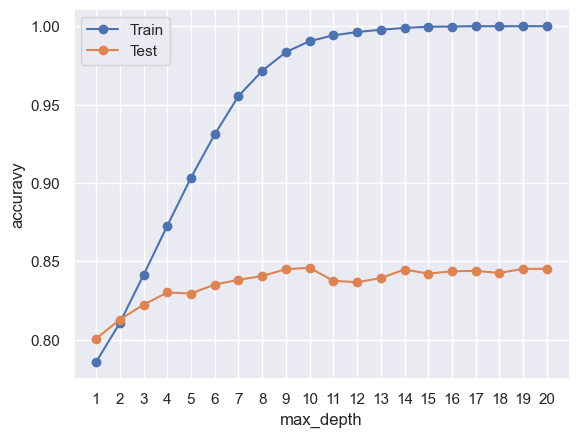

In [39]:
import math

# Set integers for x axis
new_x_ticks = range(math.floor(min(values)), math.ceil(max(values))+1)
plt.xticks(new_x_ticks)
# Plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("accuravy")
plt.show()

In [40]:
# Instantiate the estimator 
model = XGBClassifier(random_state=42)

# Train  
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
acc = round(accuracy_score(y_test, y_pred),3)
print('Accuracy: ', acc)
pre = round(precision_score(y_test, y_pred),3)
print('Precision: ', pre) 
rec = round(recall_score(y_test, y_pred),3)
print('Recall: ',rec) 
f1 = round(f1_score(y_test, y_pred),3)
print('F1: ', f1) 
roc = round(roc_auc_score(y_test, y_pred),3) 
print('ROC: ', roc)

Accuracy:  0.835
Precision:  0.825
Recall:  0.744
F1:  0.783
ROC:  0.82


[<a href="#content">Back to top</a>]

## Hyperparameter tuning  <a name="11"></a>

In [41]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [4],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create the model
model = XGBClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                          cv=5, scoring='accuracy', verbose=2) 
grid_search.fit(X_train, y_train) 

# Print the best parameters and score
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=1.0; total time=   1.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=1.0; total time=   1.1s
[CV] END c

In [42]:
# Evaluate XGBClassifier on train and test sets with different tree depths
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 21)]
# evaluate a decision tree for each depth
for i in values:
 # configure the model
 model_= XGBClassifier(max_depth=i,
                       colsample_bytree=1.0,
                       learning_rate=0.3,
                       n_estimators=300,
                       subsample=0.8)
 # fit model_ on the training dataset
 model_.fit(X_train, y_train)
 # evaluate on the train dataset
 train_yhat = model_.predict(X_train)
 train_acc = accuracy_score(y_train, train_yhat)
 train_scores.append(train_acc)
 # evaluate on the test dataset
 test_yhat = model_.predict(X_test)
 test_acc = accuracy_score(y_test, test_yhat)
 test_scores.append(test_acc)
 # summarize progress
 print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

>1, train: 0.803, test: 0.802
>2, train: 0.846, test: 0.821
>3, train: 0.894, test: 0.832
>4, train: 0.937, test: 0.834
>5, train: 0.969, test: 0.833
>6, train: 0.989, test: 0.844
>7, train: 0.997, test: 0.842
>8, train: 0.999, test: 0.842
>9, train: 1.000, test: 0.846
>10, train: 1.000, test: 0.846
>11, train: 1.000, test: 0.849
>12, train: 1.000, test: 0.844
>13, train: 1.000, test: 0.851
>14, train: 1.000, test: 0.843
>15, train: 1.000, test: 0.850
>16, train: 1.000, test: 0.851
>17, train: 1.000, test: 0.846
>18, train: 1.000, test: 0.847
>19, train: 1.000, test: 0.849
>20, train: 1.000, test: 0.846


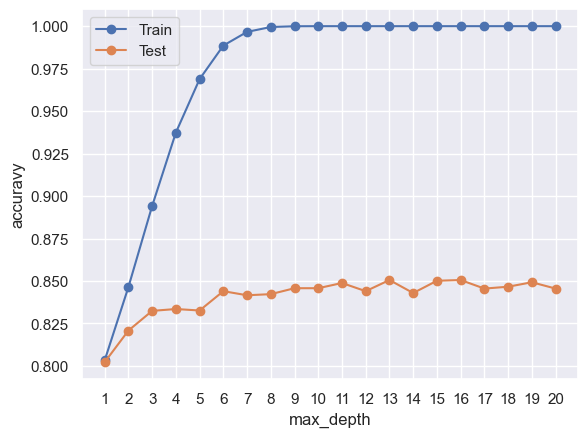

In [43]:
# Set integers for x axis
new_x_ticks = range(math.floor(min(values)), math.ceil(max(values))+1)
plt.xticks(new_x_ticks)
# Plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("accuravy")
plt.show()

In [44]:
# ML 
model= XGBClassifier(max_depth=4,
                     colsample_bytree=1.0,
                     learning_rate=0.3,
                     n_estimators=300,
                     subsample=0.8)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
acc = round(accuracy_score(y_test, y_pred),3)
print('Accuracy: ', acc)
pre = round(precision_score(y_test, y_pred),3)
print('Precision: ', pre) 
rec = round(recall_score(y_test, y_pred),3)
print('Recall: ',rec) 
f1 = round(f1_score(y_test, y_pred),3)
print('F1: ', f1) 
roc = round(roc_auc_score(y_test, y_pred),3) 
print('ROC: ', roc)

Accuracy:  0.834
Precision:  0.811
Recall:  0.759
F1:  0.784
ROC:  0.821


In [47]:
from sklearn.model_selection import cross_val_score
import optuna

def objective(trial):
    """
    Objective function for Optuna hyperparameter optimization.

    Args:
        trial: An Optuna trial object.

    Returns:
        The negative accuracy score (to be minimized).
    """
    params = {
        'max_depth': 4,
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-3, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    model = XGBClassifier(**params)
    accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return -accuracy  # Optuna minimizes the objective function

# Create a study object
study = optuna.create_study(direction='minimize') 

# Run the optimization
study.optimize(objective, n_trials=10)  # Adjust n_trials as needed

# Get the best hyperparameters
best_params = study.best_params

# Train the model with the best hyperparameters
best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) 
print(f"Best Accuracy: {accuracy}")
print(f"Best Hyperparameters: {best_params}")

[I 2025-11-25 02:29:53,085] A new study created in memory with name: no-name-cc170e6b-2af5-45bf-9e97-42a51656865d
[I 2025-11-25 02:30:06,574] Trial 0 finished with value: -0.8411282984531392 and parameters: {'learning_rate': 0.09729300370891993, 'n_estimators': 368, 'subsample': 0.8500928178535572, 'colsample_bytree': 0.9594041194418436, 'gamma': 0.4374496425529689, 'reg_lambda': 0.10062729533193322, 'min_child_weight': 1}. Best is trial 0 with value: -0.8411282984531392.
[I 2025-11-25 02:30:15,113] Trial 1 finished with value: -0.7777979981801637 and parameters: {'learning_rate': 0.009006419348570128, 'n_estimators': 167, 'subsample': 0.8104934629349303, 'colsample_bytree': 0.6023472537004555, 'gamma': 0.582337507065344, 'reg_lambda': 0.2078613926222976, 'min_child_weight': 4}. Best is trial 0 with value: -0.8411282984531392.
[I 2025-11-25 02:30:22,923] Trial 2 finished with value: -0.7728389444949955 and parameters: {'learning_rate': 0.0074216319700845775, 'n_estimators': 149, 'subsa

Best Accuracy: 0.844891708597681
Best Hyperparameters: {'learning_rate': 0.09729300370891993, 'n_estimators': 368, 'subsample': 0.8500928178535572, 'colsample_bytree': 0.9594041194418436, 'gamma': 0.4374496425529689, 'reg_lambda': 0.10062729533193322, 'min_child_weight': 1}


In [48]:
# Evaluate XGBClassifier on train and test sets with different tree depths
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 21)]
# evaluate a decision tree for each depth
for i in values:
 # configure the model
 model_ = XGBClassifier(max_depth=i,
                        colsample_bytree=0.9594041194418436,
                        learning_rate=0.09729300370891993,
                        min_child_weight=1,
                        n_estimators=368,
                        subsample=0.8500928178535572,
                        reg_lambda=0.10062729533193322,
                        gamma=0.4374496425529689)
 # fit model_ on the training dataset
 model_.fit(X_train, y_train)
 # evaluate on the train dataset
 train_yhat = model_.predict(X_train)
 train_acc = accuracy_score(y_train, train_yhat)
 train_scores.append(train_acc)
 # evaluate on the test dataset
 test_yhat = model_.predict(X_test)
 test_acc = accuracy_score(y_test, test_yhat)
 test_scores.append(test_acc)
 # summarize progress
 print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

>1, train: 0.787, test: 0.804
>2, train: 0.818, test: 0.816
>3, train: 0.854, test: 0.828
>4, train: 0.890, test: 0.836
>5, train: 0.927, test: 0.843
>6, train: 0.955, test: 0.845
>7, train: 0.974, test: 0.846
>8, train: 0.986, test: 0.845
>9, train: 0.993, test: 0.854
>10, train: 0.997, test: 0.849
>11, train: 0.998, test: 0.853
>12, train: 0.999, test: 0.850
>13, train: 0.999, test: 0.851
>14, train: 0.999, test: 0.852
>15, train: 0.999, test: 0.851
>16, train: 1.000, test: 0.848
>17, train: 1.000, test: 0.853
>18, train: 1.000, test: 0.849
>19, train: 1.000, test: 0.851
>20, train: 1.000, test: 0.845


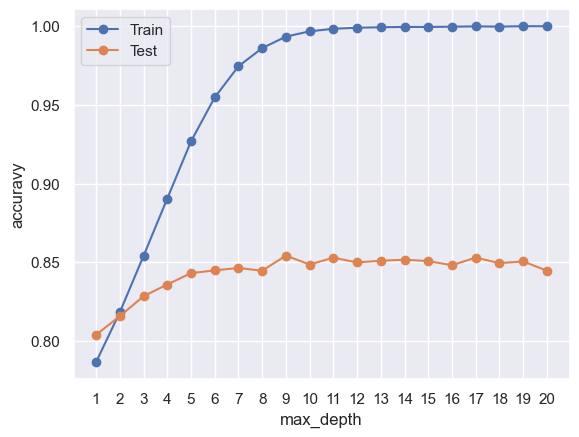

In [49]:
# Set integers for x axis
new_x_ticks = range(math.floor(min(values)), math.ceil(max(values))+1)
plt.xticks(new_x_ticks)
# Plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("accuravy")
plt.show()

[<a href="#content">Back to top</a>]

## Final ML model  <a name="12"></a>

In [50]:
model = XGBClassifier(max_depth=3,
                        colsample_bytree=0.9594041194418436,
                        learning_rate=0.09729300370891993,
                        min_child_weight=1,
                        n_estimators=368,
                        subsample=0.8500928178535572,
                        reg_lambda=0.10062729533193322,
                        gamma=0.4374496425529689)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
acc = round(accuracy_score(y_test, y_pred),3)
print('Accuracy: ', acc)
pre = round(precision_score(y_test, y_pred),3)
print('Precision: ', pre) 
rec = round(recall_score(y_test, y_pred),3)
print('Recall: ',rec) 
f1 = round(f1_score(y_test, y_pred),3)
print('F1: ', f1) 
roc = round(roc_auc_score(y_test, y_pred),3) 
print('ROC: ', roc)

Accuracy:  0.828
Precision:  0.809
Recall:  0.747
F1:  0.776
ROC:  0.815


[<a href="#content">Back to top</a>]

## Plot the learning curve <a name="13"></a>

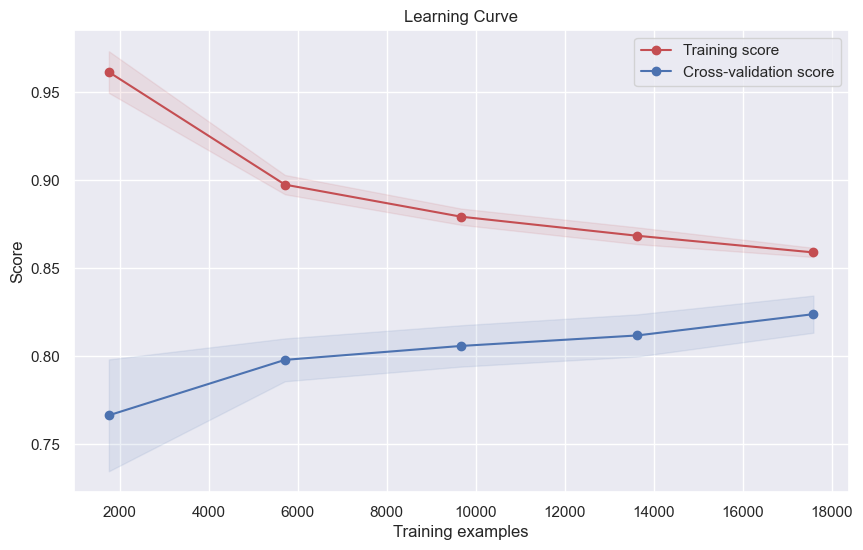

In [51]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="b",
)
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, "o-", color="b", label="Cross-validation score")
plt.legend(loc="best")
plt.show()

[<a href="#content">Back to top</a>]

## AUC <a name="14"></a>

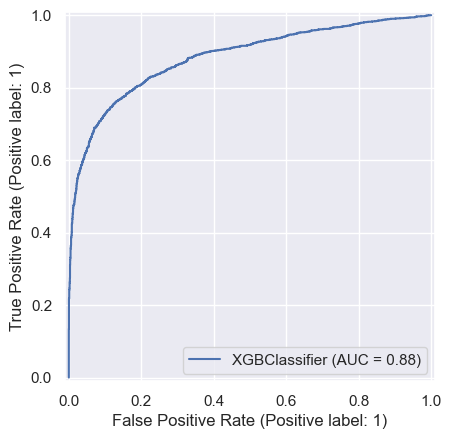

In [52]:
from sklearn.metrics import RocCurveDisplay

svc_disp = RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

[<a href="#content">Back to top</a>]

## Confusion matrix <a name="14"></a>

[1361, 2426, 322, 462]

--- Classification Metrics ---
True Positives (TP): 1361
True Negatives (TN): 2426
False Positives (FP): 322
False Negatives (FN): 462
----------------------------



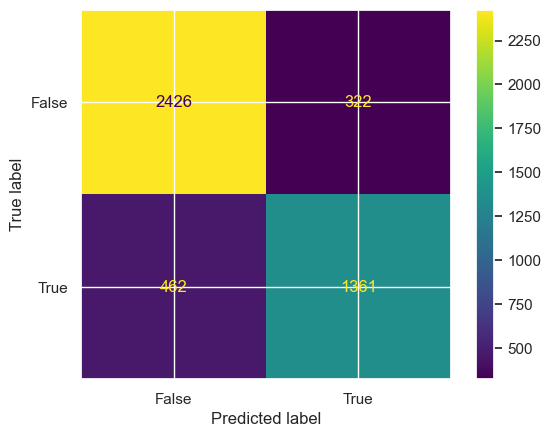

In [53]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# # Calculate the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

# Extract TP, TN, FP, FN 
# Use .ravel() to flatten the 2x2 matrix into a 1x4 array: [TN, FP, FN, TP]
TN, FP, FN, TP = confusion_matrix.ravel()
conf_matrix_list = [TP, TN, FP, FN]

# Print the list with metrics
print(conf_matrix_list)

# Print the metrics
print("\n--- Classification Metrics ---")
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print("----------------------------\n")

# Display confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

[<a href="#content">Back to top</a>]

## Matthews Correlation Coefficient 

In [54]:
import math

def matthews_corr_coeff(TP: int, TN: int, FP: int, FN: int) -> float:
    """
    Calculates the Matthews Correlation Coefficient (MCC).

    MCC is a metric used to evaluate the quality of binary classifications.
    It takes into account true positives, true negatives, false positives, 
    and false negatives, making it a reliable measure even for imbalanced classes.

    The formula is:
    MCC = (TP * TN - FP * FN) / sqrt((TP + FP)(TP + FN)(TN + FP)(TN + FN))

    Args:
        TP (int): True Positives (correctly predicted positive cases).
        TN (int): True Negatives (correctly predicted negative cases).
        FP (int): False Positives (incorrectly predicted positive cases).
        FN (int): False Negatives (incorrectly predicted negative cases).

    Returns:
        float: The Matthews Correlation Coefficient, ranging from -1 (worst) 
               to +1 (best). Returns 0.0 if the denominator is zero.
    """
    
    # Calculate the numerator: (TP * TN) - (FP * FN)
    numerator = (TP * TN) - (FP * FN)
    
    # Calculate the components of the denominator
    # Note: These components are the marginal sums (sums of rows/columns in the confusion matrix)
    term_1 = TP + FP
    term_2 = TP + FN
    term_3 = TN + FP
    term_4 = TN + FN
    
    # Calculate the denominator: sqrt((TP + FP)(TP + FN)(TN + FP)(TN + FN))
    denominator = math.sqrt(term_1 * term_2 * term_3 * term_4)
    
    # Handle the case where the denominator is zero (which means one of the marginal
    # sums is zero, indicating an ill-defined problem or a trivial prediction). 
    # In this case, MCC is conventionally set to 0.
    if denominator == 0:
        print("Warning: Denominator is zero. Returning MCC = 0.0")
        return 0.0
    
    # Calculate the final MCC value
    mcc = numerator / denominator
    return mcc

# tp1, tn1, fp1, fn1 = [9090, 6115, 1966, 3201]
tp1, tn1, fp1, fn1 = conf_matrix_list
mcc1 = matthews_corr_coeff(tp1, tn1, fp1, fn1)
print(f"---  Model ---")
print(f"TP={tp1}, TN={tn1}, FP={fp1}, FN={fn1}")
print(f"MCC: {mcc1:.4f}\n")

---  Model ---
TP=1361, TN=2426, FP=322, FN=462
MCC: 0.6390



[<a href="#content">Back to top</a>]

## Classification report <a name="14"></a>

In [56]:
# Classification report 
from sklearn.metrics import classification_report

# Print the classification report 
target_names = ['Active (target 1) ', 'Inactive (target 0)']
print(classification_report(y_test, y_pred, target_names=target_names))

                     precision    recall  f1-score   support

 Active (target 1)        0.84      0.88      0.86      2748
Inactive (target 0)       0.81      0.75      0.78      1823

           accuracy                           0.83      4571
          macro avg       0.82      0.81      0.82      4571
       weighted avg       0.83      0.83      0.83      4571



[<a href="#content">Back to top</a>]